In [2]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc
#from google.colab import drive
#drive.mount('/content/drive')
#!ls "/content/drive/MyDrive"


2024-02-15 10:06:07.291402: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 10:06:08.211040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 10:06:08.231333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 10:06:12.508164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [42]:
from sklearn.model_selection import train_test_split

In [43]:
path = '/home/johnm100/researchproject/Undergrad-Research/examples/examples/data/'
def load_data(perc = .2):
    total_data = 399
    from sklearn.model_selection import train_test_split
    x_img = np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter=',').astype('float32')
    x_fea = np.genfromtxt(path +'ffea_pi0_10-15gev.csv', delimiter=',').astype('float32')
    y_lab = keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter=','), num_classes=2)
    x_img_train,x_img_test,x_fea_train,x_fea_test, y_lab_train,y_lab_test = train_test_split(x_img,x_fea,y_lab,test_size = perc, random_state = 42, stratify = y_lab)



    # offset = 200
    # x_img_train = np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter=',')[0:total_data-offset,0:-1].astype('float32')
    # x_img_test = np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter=',')[total_data-offset-1:,0:-1].astype('float32')
    # x_fea_train = np.genfromtxt(path +'ffea_pi0_10-15gev.csv', delimiter=',')[0:total_data-offset].astype('float32')
    # x_fea_test = np.genfromtxt(path + 'ffea_pi0_10-15gev.csv', delimiter=',')[total_data-offset-1:].astype('float32')
    # y_lab_train = keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter=',')[0:total_data-offset], num_classes=2)
    # y_lab_test = keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter=',')[total_data-offset-1:], num_classes=2)
    # reshape takes in the # of images, the dimensions we want (5, 5) and the # of channels (1)
    return((x_img_train.reshape(len(x_img_train), 5, 5, 1), x_img_test.reshape(len(x_img_test), 5, 5, 1)),
           (x_fea_train, x_fea_test), (y_lab_train, y_lab_test))



#This cell contains the function that will pull data from the proper location, and partition it into training and testing data. 
#The 'path' variable simply specifies where the data for the model is to be pulled from
#Under our 'load data' function, we see the data being partitioned into the training and testing data. 

#Training: 
#The training for the network uses two kinds of inputs (denoted by the two different x inputs, x_img_train and x_fea_train ), with each coming from a different file. 
#y_lab_train contains labels that are assigned based on the two x inputs 

#x_img_train: uses data from 'fimg_pi0_10-15gev.csv'. These are simply images of the clusters. The data in this 
#file is pixel information. 

#x_fea_train: uses data from 'ffea_pi0_10-15gev.csv' The 7 colums in this file are energy in a cluster,
#phi and eta (position of cluster), xx xy and yy (2nd moment of inertia of a cluster), and probability of fit


#Testing:
#x_img_test and x_feature_test serve as input data to be used during the testing phase. 
#y_lab_test contains the labels that are to be assigned during the testing phase that will be evaluated for accuracy. 

#x_img_test: uses same file as x_img_train but not same data (presumably)
#x_fea_test: uses same file as x_fea_train but not same data (presumably)

#Question: When you have two x inputs, how is y related to them? What kind of conditions do the two different inputs have to meet to be assigned
#with a given label? 

In [27]:
def make_model(_img_train, _fea_train):
    img_inputs = keras.layers.Input(shape=_img_train.shape[1:], name='image_input') # keras.layers.input specify the shape and data type of the input data that will be fed into a neural network model
    # kernal size is the dimensions of the scanning matrix (weights) that will form the filter
    conv1 = keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='conv1')(img_inputs) #keras.layers.Conv2D takes 4 parameters: filters (detects different features in input data), kernel size, activation function (relu in this case). 
    conv2 = keras.layers.Conv2D(9, kernel_size=(2,2), activation='relu', name='conv2')(conv1) #Applies an additional convolution to img_inputs
    pool = keras.layers.MaxPooling2D((2, 2))(conv2) #MaxPooling reduces the spatial dimensions (width and height) of the input data, which helps reduce the computational load and control overfitting. Max pooling retains the most important information from the input by selecting the maximum value from a set of values within a local neighborhood.
    flat = keras.layers.Flatten()(pool) #Converts data from a 3D tensor into a 1D vector 

    fea_inputs = keras.layers.Input(shape=_fea_train.shape[1:], name='feature_input') #Does the same thing as the img_inputs line at the top of this cell, except for fea_inputs 
    dense1 = keras.layers.Dense(3, activation='relu', name='dense1')(fea_inputs) #Adds a dense layer (every input is connected to every output by a weight). 

    concat = keras.layers.Concatenate(name='combined')([flat, dense1]) #concatenates the features from 'flat' with those from 'dense1' 
    output = keras.layers.Dense(2, activation='softmax', name='outputs')(concat) #adds a dense layer for generating the final output of the neural network. 

    model = keras.models.Model(inputs=[img_inputs, fea_inputs], outputs=output, name='model')
    # keras.utils.plot_model(model, show_shapes=True)
    return model

In [28]:
((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data()

#The variables in the tuple on the LHS are new variables that will be assigned to the outputs of the load_data 
#function that we created earlier. 

#x_img_train,x_img_test,x_fea_train x_fea_test, y_lab_train, y_lab_test = img_train, img_test, fea_train, fea_test, y_lab_train, y_lab_test
#respectively (I assume)((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data() 


(199, 5, 5, 1)
(199, 7)
(199, 2)


/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


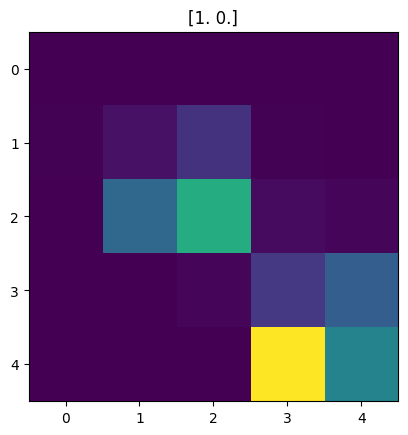

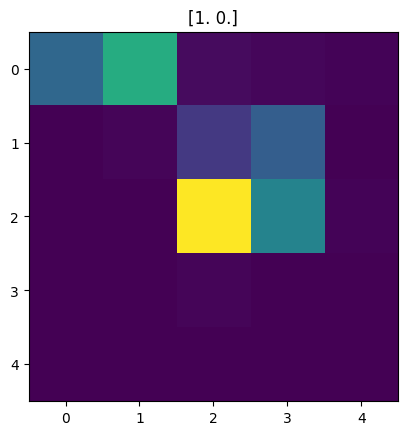

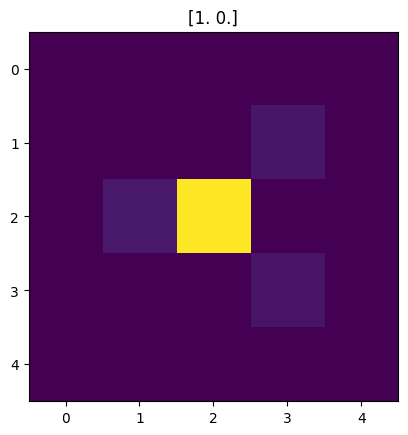

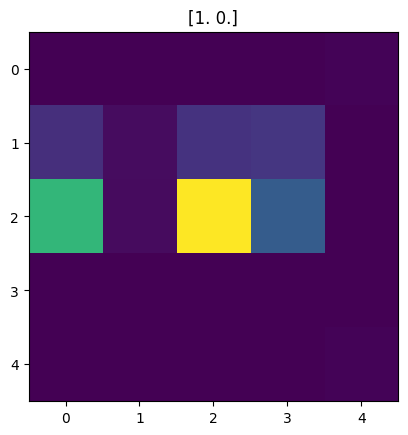

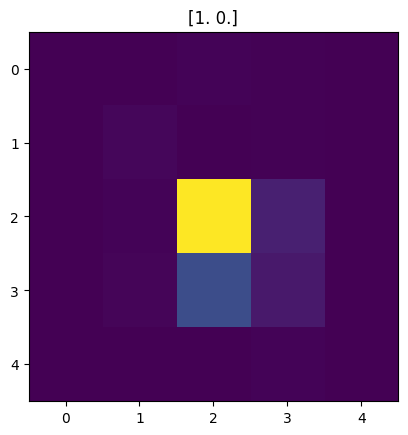

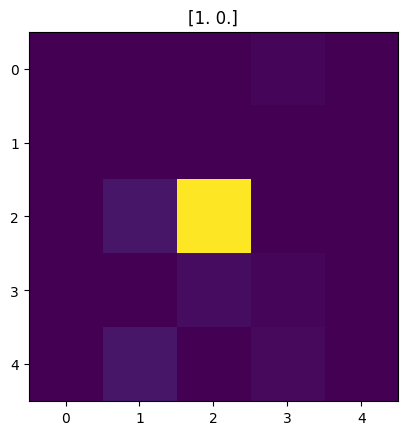

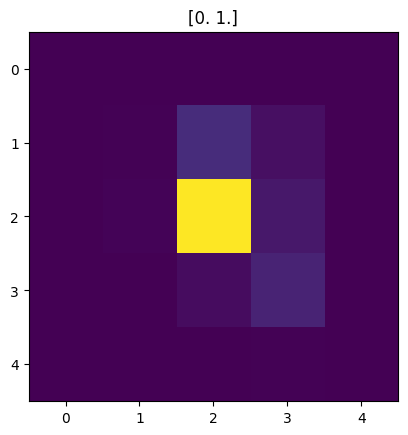

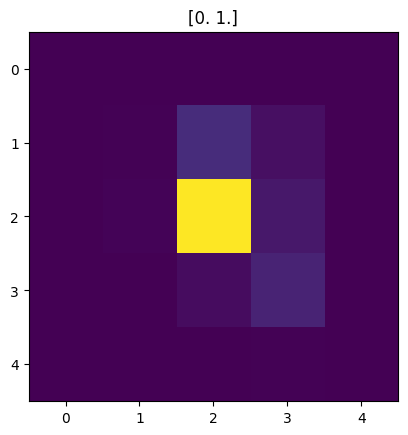

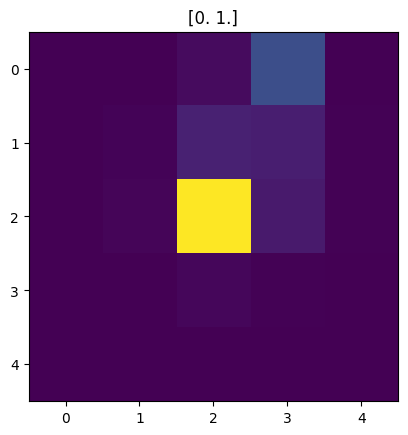

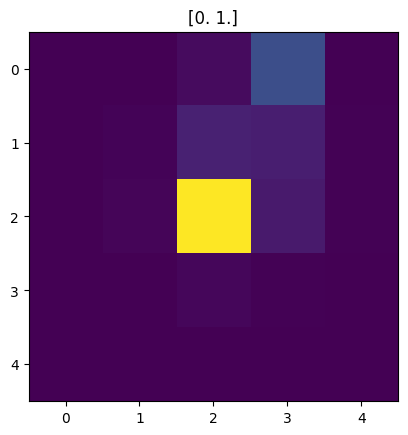

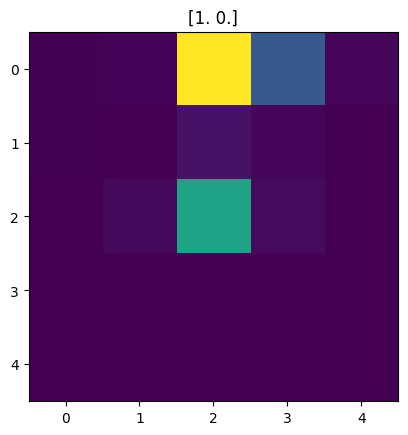

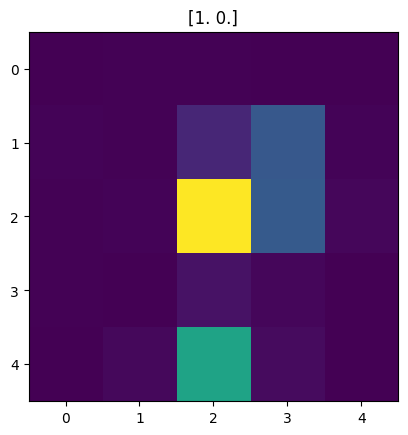

In [29]:
print(img_train.shape)
print(fea_train.shape)
print(y_lab_train.shape)

for i, data in enumerate(zip(img_train, y_lab_train)):
  img, label = data
  plt.imshow(img)
  plt.title(label)
  plt.show()
  if i>10:
    break

#The code above iterates through the training images, assigns them a label from y_lab_train, and displays them below. 
#Question: What does 1.0 vs 0.1 mean? 
  
  #1,0 = non-pileup
  #0,1 = pileup


In [30]:
model = make_model(img_train, fea_train)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#The function make_model is where wec created our convolutions and dense layers. A variable called "model" 
#is being attached to it 

#model.compile configures the learning process of the neural networks. 
#The optimizer is "adam" which is a gradient-based optimizer 
#Loss is the function to be minimized, and this one is 'categorical crossentropy". This is a useful function for multi-class problems 
#Metrics is what is to be monitored during the training. Accuracy measures the portion of correctly identified samples. 


In [62]:
!pip install pydot 
!pip install graphviz 

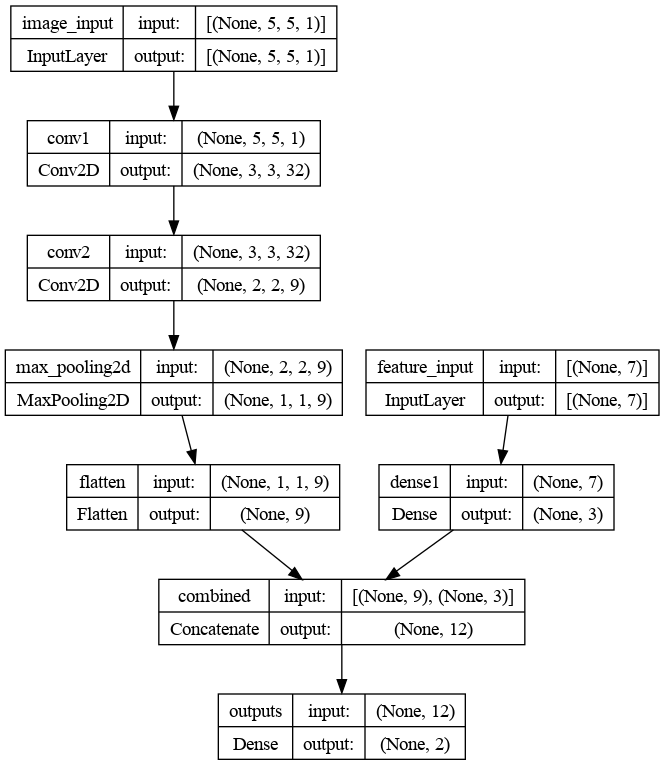

In [8]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
import matplotlib.pyplot as plt 
((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data(.5) 
y_lab_test = np.argmax(y_lab_test, axis=1)
y_lab_test_state = np.where(y_lab_test == 0,1,0)

y_lab_train = np.argmax(y_lab_train, axis = 1)
y_lab_train_state = np.where(y_lab_train == 0,1,0)

plt.hist(y_lab_train_state, label = 'train', alpha = 0.5,density = True)
plt.hist(y_lab_test_state, label = 'test', alpha = 0.5, density = True)
plt.legend()
plt.show()

print(y_lab_train)

ValueError: cannot reshape array of size 5200 into shape (200,5,5,1)

Epoch 1/100
13/13 [==============================] - 0s 22ms/step - loss: 0.3159 - accuracy: 0.8643 - val_loss: 0.4918 - val_accuracy: 0.7475
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 0.3051 - accuracy: 0.8844 - val_loss: 0.4639 - val_accuracy: 0.8218
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 0.3169 - accuracy: 0.8643 - val_loss: 0.5235 - val_accuracy: 0.7475
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 0.3100 - accuracy: 0.8794 - val_loss: 0.4912 - val_accuracy: 0.7624
Epoch 5/100
13/13 [==============================] - 0s 13ms/step - loss: 0.3209 - accuracy: 0.8693 - val_loss: 0.4643 - val_accuracy: 0.8267
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 0.3133 - accuracy: 0.8744 - val_loss: 0.5209 - val_accuracy: 0.7475
Epoch 7/100
13/13 [==============================] - 0s 13ms/step - loss: 0.2897 - accuracy: 0.8693 - val_loss: 0.4558 - val_accuracy: 0.8218
Epoch 

<Axes: >

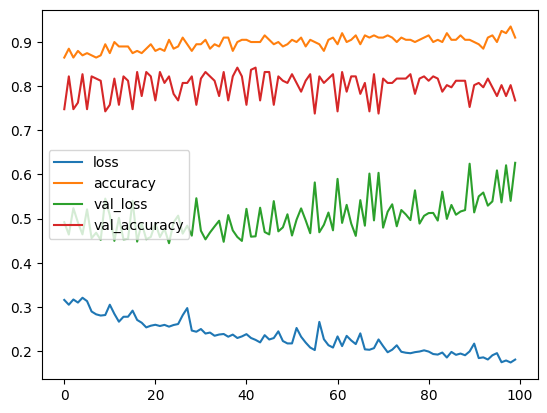

In [32]:
history = model.fit(x=[img_train, fea_train], y=y_lab_train, batch_size=16,
        validation_data=([img_test, fea_test], y_lab_test), epochs=100)
vals = pd.DataFrame(history.history)
vals.plot()
#The code above trains the model using the "fit" method.
#The parameters in the fit function start with x and y inputs. Notice that x is composed of img_train and fea_train data. 
#y is represented by the y_lab_train labels. 
#The batch size denotes the number of samples used in each gradient update. 
#validation_data contains test data used to evaluate the performance of the model after each epoch
#The 'vals' variable simply contains a history of certain metrics observed during the training, such as accuracy and loss 

In [11]:
dataset = (np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter = ',').astype('float32')).reshape(400, 1)
d = (np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter = ',')[:, 0:-1].astype('float32')).reshape(400, 25)
r = np.append(d, dataset, axis=1) # .reshape(400, 2, 1)
np.savetxt('output.txt', r, delimiter=',', fmt='%s')




In [10]:
# print(np.genfromtxt('output.txt', delimiter=','))
print(r[0])

[0.    0.    0.    0.    0.    0.036 0.24  0.729 0.038 0.    0.    1.664
 3.09  0.141 0.093 0.    0.    0.061 0.829 1.498 0.    0.    0.    4.989
 2.234 0.   ]


In [158]:
# data = sns.load_dataset('output.txt')

#sns.pairplot(r)

In [12]:
#New

input_data = [img_test,fea_test] #input of img_test and fea_test
pred = model.predict(input_data) #Makes the model make its predictions on the input
threshold = 0.5 
binary_pred = np.where(pred>threshold,1,0) #This line and the one before gives a threshold value that will cause the prediction to be rounded

#I assume that we are using the rounding method to see if the prediction should be a '1.0' or a '0.1'
#therefore, I used the threshold = 0.5 and np.where to make the set of predictions

binary_pred = np.argmax(binary_pred, axis=1)
pred_state = np.where(binary_pred == 0, 1, 0)

y_lab_test = np.argmax(y_lab_test, axis=1)
y_lab_test_state = np.where(y_lab_test == 0,1,0)

#The code above converts [1,0] and [0,1] into 1 and 0 (states) by looking at the position of the maximum number. If the 1 is in the first position, 
#the element is turned into a 1. If the 1 is in the 2nd position, the element is converted into a 0. 

2/2 [==============================] - 0s 7ms/step
(52, 2)


[[34  2]
 [ 3 13]]
Confusion Matrix:


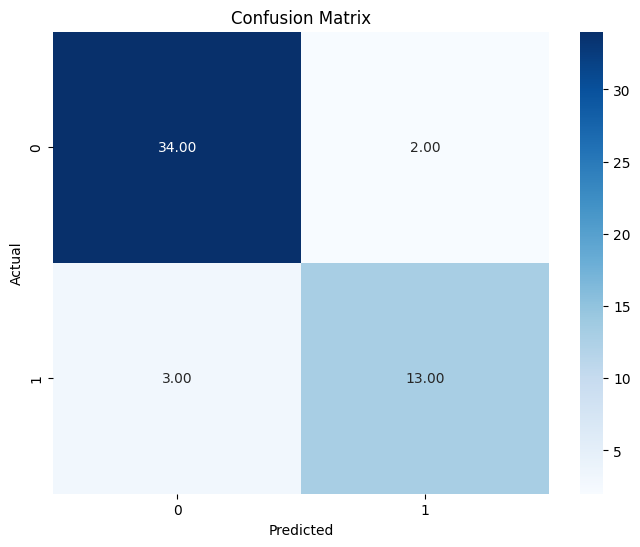

In [25]:

cm = confusion_matrix(y_lab_test_state, pred_state)

print(cm)
# Display the confusion matrix
print("Confusion Matrix:")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_lab_test), yticklabels=np.unique(y_lab_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [1]:
incorrect_indeces = np.where(y_lab_test_state != pred_state)
print(incorrect_indeces)

#The code above is made to show the indices of the elements where y_lab_test_state and pred_state are not in agreement. 


NameError: name 'np' is not defined

In [14]:
#I have the idea to print the testing images that correspond to the indices of the incorrect predictions so that we may look at the 
#images that the model got incorrect. 

plt.plot(x_img_test[incorrect_indeces])

print(img_test.shape)
print(type(img_test))





(52, 5, 5, 1)
<class 'numpy.ndarray'>
